<a href="https://colab.research.google.com/github/poku0857643/Cancer-classification-practice/blob/main/cancer_classification_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#data handling
import numpy as np
import pandas as pd
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.feature_selection import mutual_info_classif

#classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

#performance metrics
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

In [4]:
#read data

file_url = 'http://github.com/vappiah/Machine-Learning-Tutorials/raw/main/data/cancer_gene_expression.zip'

dataframe = pd.read_csv(file_url)

In [5]:
#data exploration and cleaning
print(dataframe.shape)

(801, 8001)


In [6]:
print(dataframe.columns[0:3])

Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')


In [7]:
dataframe.columns[-1]

'Cancer_Type'

In [9]:
datanul = dataframe.isnull().sum()
g=[i for i in datanul if i >0]
print('columns with missing value:%d'%len(g))

columns with missing value:0


In [10]:
print(dataframe['Cancer_Type'].value_counts())

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Cancer_Type, dtype: int64


<Axes: >

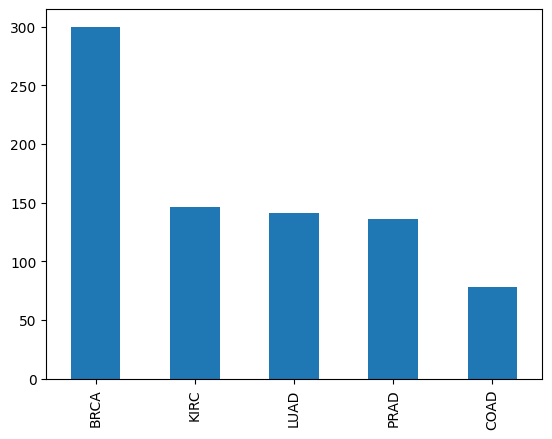

In [11]:
dataframe['Cancer_Type'].value_counts().plot.bar()

In [13]:
#data preprocessing
x = dataframe.iloc[:,0:-1]
y = dataframe.iloc[:,-1]

In [14]:
x.shape

(801, 8000)

In [15]:
y.shape

(801,)

In [16]:
#encode labels
label_encoder=LabelEncoder()
label_encoder.fit(y)
y_encoded=label_encoder.transform(y)
labels=label_encoder.classes_
classes=np.unique(y_encoded)

In [17]:
#data splitting
x_train,x_test, y_train, y_test = train_test_split(x,y_encoded, test_size=0.2,random_state=42)

In [18]:
#scale data beteeen 0 nad 1
min_max_scaler=MinMaxScaler()
x_train_norm=min_max_scaler.fit_transform(x_train)
x_test_norm=min_max_scaler.fit_transform(x_test)



In [19]:
type(x_train)

pandas.core.frame.DataFrame

In [20]:
x_train.iloc[0,3]

2.18164326123

In [21]:
x_train_norm[0,3]

0.4671305057022768

In [22]:
#feature selection
MI=mutual_info_classif(x_train_norm, y_train)

In [23]:
n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]

In [24]:
x_train_selected=x_train_norm[:, selected_scores_indices]
x_test_selected=x_test_norm[:,selected_scores_indices]

In [25]:
x_train_selected.shape

(640, 300)

In [26]:
x_test_selected.shape

(161, 300)

In [28]:
#Model training -RF classifier
RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(x_train_selected, y_train)
y_pred = RF.predict(x_test_selected)
pred_prob = RF.predict_proba(x_test_selected)

In [30]:
#Model evaluation
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test, y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test, y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test, y_pred, average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1-score
f1score = np.round(f1_score(y_test,y_pred, average = 'weighted'),4)
print('f1score:%0.4f'%f1score)

report=classification_report(y_test, y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9675
precision:0.9754
recall:0.9752
f1score:0.9751


classification report


              precision    recall  f1-score   support

        BRCA       0.97      0.98      0.98        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      1.00      1.00        28
        LUAD       0.92      0.92      0.92        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.98       161
   macro avg       0.98      0.97      0.97       161
weighted avg       0.98      0.98      0.98       161



In [34]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,index=labels, columns=labels)

In [35]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,59,0,0,1,0
COAD,0,15,0,1,0
KIRC,0,0,28,0,0
LUAD,2,0,0,22,0
PRAD,0,0,0,0,33


Text(50.722222222222214, 0.5, 'True Labels')

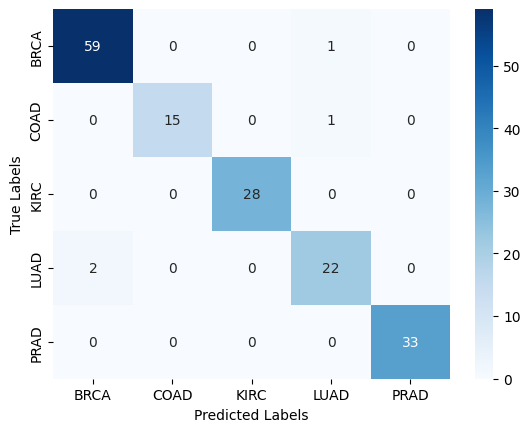

In [36]:
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [37]:
disp = plot_confusion_matrix(RF,x_test_selected, y_test,xticks_rotation='vertical',
                             cmap='Blues', display_labels=labels)

NameError: ignored

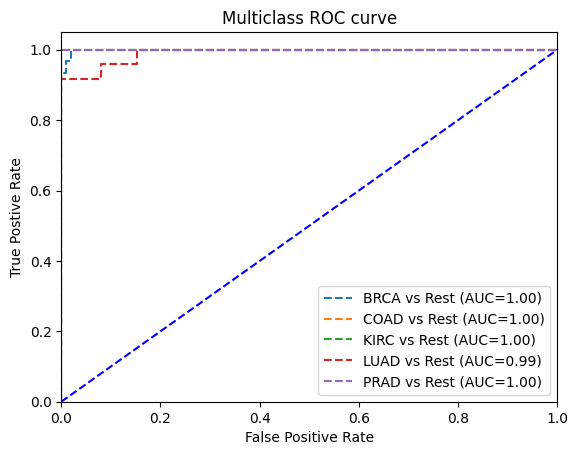

In [40]:
y_test_binarized=label_binarize(y_test, classes=classes)

fpr ={}
tpr={}
thresh={}
roc_auc=dict()

n_class = classes.shape[0]

for i in range(n_class):
  fpr[i],tpr[i],thresh[i] = roc_curve(y_test_binarized[:,i],pred_prob[:,i])
  roc_auc[i] =auc(fpr[i], tpr[i])

  plt.plot(fpr[i],tpr[i], linestyle='--',
           label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))


plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.legend(loc='lower right')
plt.show()
